In [36]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
#import jieba
#!pip uninstall googletrans -y
#import googletrans
#googletrans.__version__
#!pip install git+https://github.com/bfsujason/bertalign.git
#!pip install googletrans
#!pip install sentence_splitter
#!pip install faiss-cpu
#!pip install numba
#!pip install sentence_transformers
#!pip install jieba

from bertalign import Bertalign



from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("distiluse-base-multilingual-cased-v1")

def read_cn_text_from_file(filename):
  """Reads text from a file and returns a list of lines."""
  with open(filename, "r") as f:
    lines = f.readlines()

  for i in range(len(lines)):
    lines[i] = lines[i].strip()

  sentences = []
  for line in lines:
    sentences.extend(line.split("."))
 
  return sentences#'''
    
def read_text_from_file(filename):
  """Reads text from a file and returns a list of strings, where each string is a sentence."""

  with open(filename, "r") as f:
    text = f.read()

  text = text.replace("\n", "")

  sentences = text.split(".")

  sentences = [sentence for sentence in sentences if sentence]

  return sentences

In [37]:
en_transcription_file = 'stimuli_task-lppEN_section-1.txt'
fr_transcription_file  = 'stimuli_task-lppFR_section-1.txt'
cn_transcription_file  = 'stimuli_task-lppCN_section-1.txt'

en_lines = read_text_from_file(en_transcription_file)
cn_lines = read_cn_text_from_file(cn_transcription_file)
fr_lines = read_text_from_file(fr_transcription_file)

print(len(en_lines))
print(len(cn_lines))
print(len(fr_lines))

pd.DataFrame(en_lines).to_csv('english_sentences.csv')
pd.DataFrame(cn_lines).to_csv('chinese_sentences.csv')
pd.DataFrame(fr_lines).to_csv('french_sentences.csv')

99
319
110


In [66]:
en_lines[0:2]

['Once, when I was six years old, I saw a magnificent picture in a book about the primeval forest called Real Life Stories',
 'It showed a boa constrictor swallowing a wild animal']

In [67]:
fr_lines[0:2]

["Lorsque j'avais 6 ans, j'ai vu, une fois, une magnifique image dans un livre sur laforêt vierge qui s'appelait Histoire Vécu",
 'Ça représentait un serpent bois qui avalait un fauve, voilà la copie du dessin']

In [69]:
cn_lines[0:6]

['當我還只有六歲的時候',
 '在一本描寫原始森林的',
 '名叫真實的故事的書中',
 '看到了一幅精彩的插畫',
 '畫的是一條網舌正在吞時一隻大野獸',
 '夜頭上就是那幅畫的模本']

In [56]:
#p#lt.plot(fr_embeddings[0])   #BERT Google
#plt.plot(en_embeddings[0])   #BERT Google

np.corrcoef(fr_embeddings[0], en_embeddings[1])[0,1]

0.14558849368506332

### FIrst, run embedings and correlate via raw 'sentences'

110
99
319
(110, 512)
(99, 512)
(319, 512)
(99, 110)
(99, 319)
(110, 319)


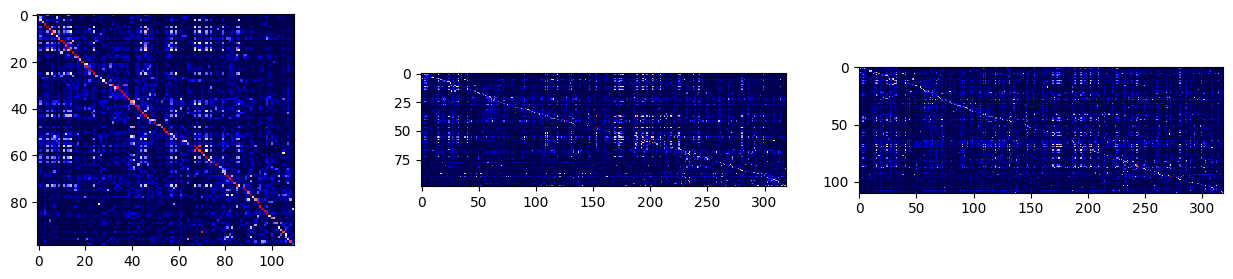

In [43]:
fr_embeddings = []
for curr_line in fr_lines:
    fr_embeddings.append(embedder.encode(curr_line))
print(len(fr_embeddings))

en_embeddings = []
for curr_line in en_lines:
    en_embeddings.append(embedder.encode(curr_line))
print(len(en_embeddings))

cn_embeddings = []
for curr_line in cn_lines:
    cn_embeddings.append(embedder.encode(curr_line))
print(len(cn_embeddings))


fr_embeddings = np.asarray(fr_embeddings)
en_embeddings = np.asarray(en_embeddings)
cn_embeddings = np.asarray(cn_embeddings)


print(fr_embeddings.shape)
print(en_embeddings.shape)
print(cn_embeddings.shape)


l_en = en_embeddings.shape[0]
l_fr = fr_embeddings.shape[0]
l_cn = cn_embeddings.shape[0]


res_en_fr = np.zeros((l_en, l_fr)) 
print(res_en_fr.shape)

for i in range(l_en):
  curr_1 = en_embeddings[i,:]
  for j in range(l_fr):
    curr_2 = fr_embeddings[j,:]
    res_en_fr[i,j] = (np.corrcoef(curr_1, curr_2)[0,1])

######
res_en_cn = np.zeros((l_en, l_cn)) 
print(res_en_cn.shape)

for i in range(l_en):
  curr_1 = en_embeddings[i,:]
  for j in range(l_cn):
    curr_2 = cn_embeddings[j,:]
    res_en_cn[i,j] = (np.corrcoef(curr_1, curr_2)[0,1])


######
res_fr_cn = np.zeros((l_fr, l_cn)) 
print(res_fr_cn.shape)

for i in range(l_fr):
  curr_1 = fr_embeddings[i,:]
  for j in range(l_cn):
    curr_2 = cn_embeddings[j,:]
    res_fr_cn[i,j] = (np.corrcoef(curr_1, curr_2)[0,1])


fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16, 3));

min = 0.1
max = 1
#count = :

ax[0].imshow(res_en_fr, cmap = 'seismic', interpolation = 'nearest', vmin = min, vmax = max);
ax[1].imshow(res_en_cn[:, :], cmap = 'seismic', interpolation = 'nearest', vmin = min, vmax = max);
ax[2].imshow(res_fr_cn[:, :], cmap = 'seismic', interpolation = 'nearest', vmin = min, vmax = max);


#plt.colorbar();

### As can be seen, this suffers from the much-longer chinese parts/units/sentences (?), hence we'll align this better semantically

In [72]:
#aligner.print_sents()

Source language: English, Number of sentences: 99
Target language: Chinese, Number of sentences: 319
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 99 English sentences to 319 Chinese sentences

(136, 512)
(136, 512)
(136, 136)


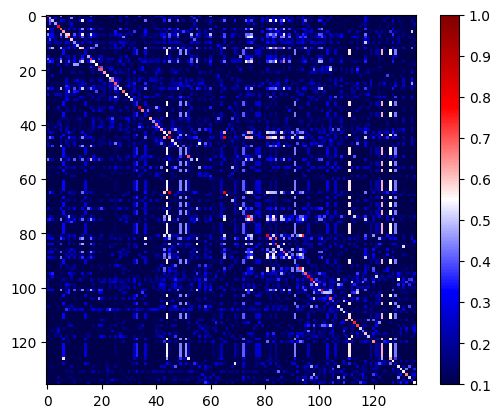

In [59]:
en_src = '\n '.join(en_lines)
en_src[:200]

cn_tgt = '\n '.join(cn_lines)
cn_tgt[:200]

aligner = Bertalign(en_src, cn_tgt, is_split=True)
aligner.align_sents()

en_lines_array = np.asarray(en_lines)
cn_lines_array = np.asarray(cn_lines)

new_english_sents = []
new_chinese_sents = []
new_en_embeddings = []
new_cn_embeddings = []

n_new_sents = len(aligner.result)

for curr_sent in range(n_new_sents):

    #english
    res = (np.array(aligner.result[curr_sent][0]).astype(int))

    new_eng_sent = ' '.join(en_lines_array[res])
    new_english_sents.append(new_eng_sent)
    new_en_embeddings.append(embedder.encode(new_eng_sent))
    
    #chinese
    res = (np.array(aligner.result[curr_sent][1]).astype(int))
    new_chinese_sent = ' '.join(cn_lines_array[res])
    new_chinese_sents.append(new_chinese_sent)
    new_cn_embeddings.append(embedder.encode(new_chinese_sent))


new_en_embeddings = np.asarray(new_en_embeddings)
new_cn_embeddings = np.asarray(new_cn_embeddings)

print(new_en_embeddings.shape)
print(new_cn_embeddings.shape)

l_en = new_en_embeddings.shape[0]
l_cn = new_cn_embeddings.shape[0]

######
res_en_cn = np.zeros((l_en, l_cn)) 
print(res_en_cn.shape)

for i in range(l_en):
  curr_1 = new_en_embeddings[i,:]
  for j in range(l_cn):
    curr_2 = new_cn_embeddings[j,:]
    res_en_cn[i,j] = (np.corrcoef(curr_1, curr_2)[0,1])

#res_en_cn[res_en_cn == 1] =  0
plt.imshow(res_en_cn[:, :], cmap = 'seismic', interpolation = 'nearest', vmin = min, vmax = max);
plt.colorbar()

Source language: French, Number of sentences: 110
Target language: Chinese, Number of sentences: 319
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 110 French sentences to 319 Chinese sentences

(135, 512)
(135, 512)
(136, 136)


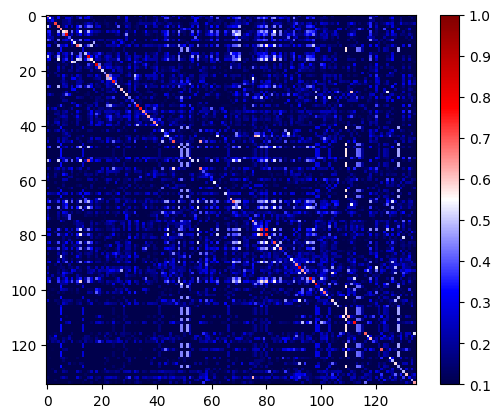

In [33]:
fr_src = '\n '.join(fr_lines)
fr_src[:200]

cn_tgt = '\n '.join(cn_lines)
cn_tgt[:200]

aligner = Bertalign(fr_src, cn_tgt, is_split=True)
aligner.align_sents()

fr_lines_array = np.asarray(fr_lines)
cn_lines_array = np.asarray(cn_lines)

new_french_sents = []
new_chinese_sents = []
new_fr_embeddings = []
new_cn_embeddings = []

n_new_sents = len(aligner.result)

for curr_sent in range(n_new_sents):

    #french
    res = (np.array(aligner.result[curr_sent][0]).astype(int))

    new_french_sent = ' '.join(fr_lines_array[res])
    new_french_sents.append(new_french_sent)
    new_fr_embeddings.append(embedder.encode(new_french_sent))
    
    #chinese
    res = (np.array(aligner.result[curr_sent][1]).astype(int))
    new_chinese_sent = ' '.join(cn_lines_array[res])
    new_chinese_sents.append(new_chinese_sent)
    new_cn_embeddings.append(embedder.encode(new_chinese_sent))


new_fr_embeddings = np.asarray(new_fr_embeddings)
new_cn_embeddings = np.asarray(new_cn_embeddings)

print(new_fr_embeddings.shape)
print(new_cn_embeddings.shape)

l_fr = new_fr_embeddings.shape[0]
l_cn = new_cn_embeddings.shape[0]

######
res_fr_cn = np.zeros((l_fr, l_cn)) 
print(res_fr_cn.shape)


for i in range(l_fr):
  curr_1 = new_fr_embeddings[i,:]
  for j in range(l_cn):
    curr_2 = new_cn_embeddings[j,:]
    res_fr_cn[i,j] = (np.corrcoef(curr_1, curr_2)[0,1])

res_fr_cn[res_fr_cn == 1] =  0
plt.imshow(res_fr_cn[:, :], cmap = 'seismic', interpolation = 'nearest', vmin = min, vmax = max);
plt.colorbar()

Source language: French, Number of sentences: 110
Target language: English, Number of sentences: 99
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 110 French sentences to 99 English sentences

(91, 512)
(91, 512)
(91, 91)


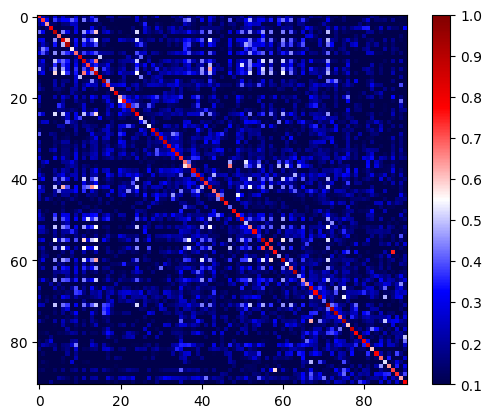

In [35]:
fr_src = '\n '.join(fr_lines)
fr_src[:200]

en_tgt = '\n '.join(en_lines)
en_tgt[:200]

aligner = Bertalign(fr_src, en_tgt, is_split=True)
aligner.align_sents()

fr_lines_array = np.asarray(fr_lines)
en_lines_array = np.asarray(en_lines)

new_french_sents = []
new_english_sents = []
new_fr_embeddings = []
new_en_embeddings = []

n_new_sents = len(aligner.result)

for curr_sent in range(n_new_sents):

    #french
    res = (np.array(aligner.result[curr_sent][0]).astype(int))
    new_french_sent = ' '.join(fr_lines_array[res])
    new_french_sents.append(new_french_sent)
    new_fr_embeddings.append(embedder.encode(new_french_sent))
    
    #english
    res = (np.array(aligner.result[curr_sent][1]).astype(int))
    new_english_sent = ' '.join(en_lines_array[res])
    new_english_sents.append(new_english_sent)
    new_en_embeddings.append(embedder.encode(new_english_sent))

new_fr_embeddings = np.asarray(new_fr_embeddings)
new_en_embeddings = np.asarray(new_en_embeddings)


print(new_fr_embeddings.shape)
print(new_en_embeddings.shape)

l_fr = new_fr_embeddings.shape[0]
l_en = new_en_embeddings.shape[0]

######
res_fr_en = np.zeros((l_fr, l_en)) 
print(res_fr_en.shape)

for i in range(l_fr):
  curr_1 = new_fr_embeddings[i,:]
  for j in range(l_en):
    curr_2 = new_en_embeddings[j,:]
    res_fr_en[i,j] = (np.corrcoef(curr_1, curr_2)[0,1])

#res_fr_en[res_fr_en == 1] =  0
plt.imshow(res_fr_en[:, :], cmap = 'seismic', interpolation = 'nearest', vmin = min, vmax = max);
plt.colorbar()